# _*Quantum-enhanced classification*_

<br>

***
<br>

### Author
Steve Jeffrey<sup></sup>

Email: <i>stephen_j_jeffrey@yahoo.com.au</i>
$$
   \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
   \newcommand{\ket}[1]{\left|{#1}\right\rangle}
   \newcommand{\bra}[1]{\left\langle{#1}\right|}
   \newcommand{\rpm}{\raisebox{.2ex}{$\scriptstyle\pm$}}
$$

In [2]:
%%javascript
// This enables line numbers in LaTeX equations
// Please note, you may need to enter and exit edit mode in the mark down 
// cells and then run them, for the equation numbers to display correctly
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

This notebook provides a detailed introduction to a quantum-enhanced method for data classification, using the algorithm, notation and datasets presented in Havlicek *et al* (2019)<sup>[1]</sup>.

For a high level overview of these methods and the implementation using [Aqua](https://qiskit.org/documentation/the_elements.html#aqua), please see the Q Experience [tutorial](https://qiskit.org/documentation/tutorials/machine_learning/01_qsvm_classification.html) and community notebooks:
1. [Variational classifier](https://github.com/Qiskit/qiskit-community-tutorials/blob/master/machine_learning/vqc.ipynb)   
2. [Kernel estimator](https://github.com/Qiskit/qiskit-community-tutorials/blob/master/machine_learning/qsvm.ipynb).

<!-- Link was: https://quantum-computing.ibm.com/jupyter/tutorial/advanced/aqua/machine_learning/qsvm_classification.ipynb -->

In this notebook we augment a classical Support Vector Machine (SVM) with a quantum algorithm for computing the kernel matrix. Havlicek *et al* (2019) also present a quantum variational method for the same classification task, however that method is not demonstrated in this tutorial.

This tutorial also shows how:
 - classical input data can be mapped to quantum states
 - symbolic programming can be used to parameterise circuits
 - a large number of circuits can be efficiently transpiled.

### Introduction to Support Vector Machines
Support Vector Machines are powerful machine learning methods for regression and classification. While SVMs can be used for multi-class classification using a simple one-versus-rest approach, we will focus on the binary classification problem. In this tutorial we will follow the exposition in Burges (1998)<sup>[2]</sup>.

Given a set of $d$-dimensional samples labelled as either 1 or -1:

\begin{equation*}
\{\mathbf{x}_i, y_i\},  i=1, \ldots, l,\; y_i = \{-1, 1\},\; \mathbf{x}_i \in \mathbb{R}^d,
\end{equation*}

we seek the hyperplane which will separate the "positive" ($y=1$) and negative ($y=-1$) samples.

If the samples are linearly separable, we have:
\begin{eqnarray}
\label{lin_sep_row1}
\mathbf{x}_i \cdot \mathbf{w} + b &\ge& +1 \;\;\; \textrm{for}\; y_i = +1\\
\label{lin_sep_row2}
\mathbf{x}_i \cdot \mathbf{w} + b &\le& -1 \;\;\; \textrm{for}\; y_i = -1
\end{eqnarray}

where $\mathbf{w}$ is the normal to the separating hyperplane, and $b/\!\!\parallel\!\mathbf{w}\!\parallel$ is the perpendicular distance from the origin to the hyperplane. We can combine Equations \ref{lin_sep_row1} and \ref{lin_sep_row2} as follows:
\begin{equation}
y_i \left(\mathbf{x}_i \cdot \mathbf{w} + b\right) - 1 \ge 0 \;\;\forall \; i.
\end{equation}

The samples which lie closest to the separating plane are known as *support vectors* and are a perpendicular distance $1/\!\!\parallel\!\mathbf{w}\!\parallel$ from the plane. To find the plane which maximally separates the samples (and therefore most likely to generalize well), we seek the separating plane of maximum *margin* by finding $\mathbf{w}$ with minimal $\parallel\!\mathbf{w}\!\parallel$. We can solve the minimization problem by switching to a Lagrangian formulation:
\begin{equation}
\label{lin_sep_lp}
L_P = \frac{1}{2} \parallel\!\!\mathbf{w}\!\!\parallel^2 - 
\sum_{i=1}^{l} \alpha_i y_i \left(\mathbf{x}_i \cdot \mathbf{w} + b\right) + 
\sum_{i=1}^{l} \alpha_i
\end{equation}
where $\alpha_i, i=1,\ldots,l$ are Lagrangian multipliers of the form $\alpha_i \ge 0$. 
The optimal solution is found by minimizing $L_P$ *i.e.* where the derivatives of $L_P$ with respect to $\mathbf{w}$, $b$ and $\alpha_i$ vanish, subject to the constraint $\alpha_i \ge 0 \; \forall \; i$. Given the $\alpha_i$, we can obtain $b$ from the Karush-Kuhn-Tucker conditions. The normal $\parallel\!\mathbf{w}\!\parallel$ is then given by:
\begin{equation}
\label{w_sum}
\mathbf{w} = \sum_i \alpha_i y_i \mathbf{x}_i
\end{equation}
and (unseen) test data can then be classified (using Equations \ref{lin_sep_row1} and \ref{lin_sep_row2}). We note the Lagrange multipliers $\alpha_i$ are non-zero for those $\mathbf{x}_i$ which are support vectors, and zero otherwise, so the classification is reduced to a sum over the support vectors $\mathbf{s}_i$:
\begin{equation}
\label{w_sum_v2}
f(\mathbf{x}) = \sum_{i=1}^{N_s} \alpha_i y_i \mathbf{s}_i \cdot\mathbf{x} + b
\end{equation}
where $N_s$ is the number of support vectors.

**Kernel method**

We can convert the *primal* formulation in Equation \ref{lin_sep_lp} to the *dual* formulation (see Burges, 1998):
\begin{equation}
\label{lin_sep_ld}
L_D = \sum_{i=1}^{l} \alpha_i - 
\frac{1}{2} \sum_{i, j=1}^{l} \alpha_i \alpha_j \: y_i y_j \: \mathbf{x}_i \cdot \mathbf{x}_j.
\end{equation}
In this case the optimal solution is found by maximizing $L_D$. The dual formulation is useful because the training data (the $\mathbf{x}_i$) only appear in the form of dot products ($\mathbf{x}_i \cdot \mathbf{x}_j$), a feature which will be very useful, as we will soon see.

<br>
In the preceding discussion we assumed the training data were linearly separable. If the data are not linearly separable, we can add *slack* variables that enable an optimal solution to be found, but still using a linear separation function. For further details see Burges (1998). An alternative approach is to map the data:
\begin{equation}
\label{svm_map}
\Phi: \mathbb{R}^d \mapsto \mathcal{H}
\end{equation}

from the original space ($\mathbb{R}^d$) into a higher dimensional space $\mathcal{H}$ and fit the separating function in $\mathcal{H}$. In the dual formulation the data only appear in dot products (see Eqn \ref{lin_sep_ld}), or in the higher dimensional space:
\begin{equation}
\label{svm_map_dp}
\Phi(\mathbf{x}_i) \cdot \Phi(\mathbf{x}_j).
\end{equation}

In practice the mapping $\Phi$ may be difficult to compute or even unknown. If we have access to a *kernel* function $K$:

\begin{equation}
\label{kernel_func}
K\left(\mathbf{x}_i, \mathbf{x}_j\right) = \Phi(\mathbf{x}_i) \cdot \Phi(\mathbf{x}_j)
\end{equation}

we don't need to explicitly know what $\Phi$ is. Once the optimal separating function has been found, the data can be classified in a manner analagous to the linearly separable case (Equation \ref{w_sum_v2}): 
\begin{eqnarray}
\label{w_sum_kernel}
f(\mathbf{x}) &=& \sum_{i=1}^{N_s} \alpha_i y_i \Phi(\mathbf{s}_i) \cdot \Phi(\mathbf{x}) + b \\
&=& \sum_{i=1}^{N_s} \alpha_i y_i K(\mathbf{s}_i, \mathbf{x}) + b.
\end{eqnarray}

We will use this method in our quantum implementation below.

In the remainder of the tutorial we will construct and use a quantum-enhanced support vector machine
as follows:
1. Prepare the training and test datasets
2. Construct a quantum circuit to implement the mapping (Equation \ref{svm_map})
3. Construct quantum circuits to compute the kernel function (Equation \ref{kernel_func})
4. Use classical methods to compute the optimal support vectors *i.e.* fit the SVM
5. Use the SVM to classify the test data.

**References**

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, "Supervised learning with quantum enhanced feature spaces," Nature **567**, 209–212 (2019), https://doi.org/10.1038/s41586-019-0980-2. An online copy is available [here](https://arxiv.org/pdf/1804.11326.pdf).

[2] Christopher J. Burges. "A tutorial on support vector machines for pattern recognition", Data mining and knowledge discovery **2**, 121–167 (1998).

### Initialisation

In [3]:
# The codes in this notebook are adapted from the SVM kernel estimation
# code in Qiskit (see the Aqua section). Qiskit codes are licensed under 
# the Apache License, Version 2.0, © Copyright IBM 2018, 2020.

import os, sys
import numpy as np
from functools import reduce
from itertools import combinations
from qiskit import IBMQ, Aer, BasicAer, __qiskit_version__
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.parametertable import ParameterTable
from qiskit.circuit.library.standard_gates import HGate
from qiskit.aqua import QuantumInstance
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.utils import optimize_svm
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data

# Helper function for displaying plots
import matplotlib.pyplot as plt
%matplotlib inline
def show_figure(fig):
    """
       Function outputs the given matplotlib plot
    """
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

# Style only works in matplotlib backend
style = {'backgroundcolor': 'lightgreen'}

### Load the dataset

First we prepare the dataset, which is used for training, testing and the final prediction.

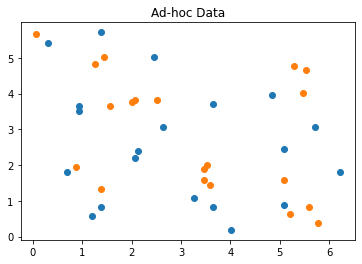

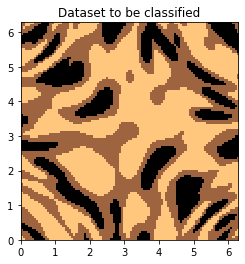

In [4]:
training_size = 20  # Number of samples used for training     
test_size = 10      # Number of samples used for testing
feature_dim = 2     # No. of features in each sample i.e. the dimension of the data
plot_data = True

gap = 0.3           # "Distance" between samples (influences how difficult it is to separate samples) of different class)
sample_Total, training_input, test_input, class_labels = ad_hoc_data(
    training_size, 
    test_size, 
    feature_dim, 
    gap, 
    plot_data
)
# The above function returns:
#  1. sample_Total is a regular 2D array of labels sampled from the underlying function
#           (for displaying the data as an image)
#  2. training_input is a dict. In the example datasets it has two entries:
#           key='A', value=2D numpy array, shape=(training_size,feature_dim)
#           key='B', same as for key='A'
#  3. test_input is a dict. In the example datasets it has two entries:
#           key='A', value=2D numpy array, shape=(test_size,feature_dim)
#           key='B', same as for key='A'
#  4. class_label is a list containing the string labels. In the example datasets they are 'A' and 'B'

# Reformat the sampled data and obtain a mapping from class name to the numeric label
training_dataset, class_to_label = split_dataset_to_data_and_labels(training_input)
test_dataset, _ = split_dataset_to_data_and_labels(test_input)
    
# The above functions return:
#  1. dataset: a list, where 
#           element 1 = numpy array of shape (m,n) where m = no. of samples*no_classes, n = dimensionality of the data
#           element 2 = 1-D numpy array of length m containing the numeric labels of the samples
#  3. class_to_label: a dictionary. In the example datasets it has two entries:
#           key='A', value=0
#           key='B', value=1 
    
# Display the data as a map  
img = plt.imshow(np.asmatrix(sample_Total).T, interpolation='nearest',
                 origin='lower', cmap='copper', extent=[0, 2*np.pi, 0, 2*np.pi])
plt.title('Dataset to be classified')
plt.show()      

### Select the device to use and initialise

In [5]:
# Account credentials are not required if using the simulator
# IBMQ.load_account()

# Get a backend
# - this returns the C++ QasmQobj simulator with noise (has an extensive set of gates)
backend = Aer.get_backend('qasm_simulator')
#  - this returns the basic Python simulator (only has u1, u2, u3, cx, id and unitary gates)
# backend = BasicAer.get_backend('qasm_simulator')

# Create a QuantumInstance (a tool for assisting with transpiling and executing circuits)
random_seed = 10598
no_shots = 1024
quantum_instance = QuantumInstance(backend, shots=no_shots, seed_simulator=random_seed,
                                   seed_transpiler=random_seed)
# Create a register of qubits
num_qubits = 2
qregs = [QuantumRegister(num_qubits, name='q')]

### Construct the feature map 

In the introduction we showed how we could use a kernel function to fit the separating function in feature space (Equation 10 above):
\begin{equation}
\label{kernel_func2}
K\left(\mathbf{x}_i, \mathbf{x}_j\right) = \Phi(\mathbf{x}_i) \cdot \Phi(\mathbf{x}_j).
\end{equation}
If a given dataset cannot be separated using feature maps computed classically, it may be worth considering a quantum approach. The quantum feature map is typically a non-linear function that maps from the original low dimensional space $\Omega \subset \mathbb{R}^d$, to a high dimensional Hilbert space $\mathcal{H}$ (see Equation 8 above): 
\begin{equation}
\Phi : \Omega \subset \mathbb{R}^d  \rightarrow \mathcal{S}\left(\mathcal{H}_2^{\otimes n}\right)
\end{equation}
where $\mathcal{H}_2 = \mathbb{C}^2$ is the single-qubit Hilbert space and $\mathcal{S}\left(\mathcal{H}_2^{\otimes n}\right)$ is a subset of the full $4^n$ dimensional Hilbert space of $n$ qubits.

To increase our chances of success, we seek feature maps which are hard to estimate classically. To proceed we define a family of feature maps, $\mathcal{U}_{\Phi(\mathbf{x})}$,
consisting of $D$ layers of Hadamard gates ($H$) and entangling blocks:
\begin{equation}
\label{U_eqn}
\mathcal{U}_{\Phi(\mathbf{x})} = \prod_D U_{\Phi(\mathbf{x})} H^{\otimes n} U_{\Phi(\mathbf{x})} H^{\otimes n},
\end{equation}
where
\begin{equation}
\label{generic_map}
U_{\Phi(\mathbf{x})} = exp \left(i \sum_{S \subseteq [n]} \phi_S(\mathbf{x}) \prod_{k \in S} P_k \right). 
\end{equation}
The feature map for a given sample, $\mathcal{U}_{\Phi(\mathbf{x})}$, is applied to the reference state $\ket{0}^n$. Feature maps of this type can be efficiently implemented using short-depth circuits, thereby enabling the algorithm to be run on quantum devices which are affected by noise (decoherence, dephasing etc.). 

<br>

#### Technical details
In Equation \ref{generic_map} the $P_k$ are gates in the Pauli group:
\begin{equation}
\label{pauli_group}
P_k \in \left\{\mathbb{1}_k, X_k, Y_k, Z_k\right\}
\end{equation}
however any orthonormal operator basis could be used.

***
&#9998; The Pauli group $G_1$ on 1 qubit consists of 16 operators:
$G_1 = \left\{\pm\mathbb{1}, \pm X, \pm Y, \pm Z, \pm i \mathbb{1}, \pm i X, \pm i Y, \pm i Z\right\} = \left\langle X, Y, Z \right\rangle$, where $X$, $Y$ and $Z$ are the Pauli operators. The Pauli group on $n$ qubits, $G_n$, is generated by tensor products of the aforementioned operators.
***
The index $S$ in Equation \ref{generic_map} describes the physical connectivities between the qubits. For $n$ fully connected qubits there are
<!--
$S \in \left\{\binom{n}{k}, k = 1,... n\right\}$ combinations. 
-->
$S \in \left\{(i,j)\!: i=1, \ldots n, j=i\!+\!1, \ldots n\right\}$ unique connections.
For short depth circuits however, we only use connections present in the physical device, thereby avoiding any additional operations required to swap qubits.
   
    
    
The function $\phi_S(\mathbf{x})$ is a non-linear classical mapping of the $n$ real coefficients of $\mathbf{x}$ into $2^n$ real coefficients (recall $\mathbf{x} \in \mathbb{R}^n$, where the number of qubits $n$ is equal to the dimension of the sample space, $d$). In this work we use low degree expansions ($\left|S\right| \leqslant d$) so the feature map can be generated using one- and two-qubit gates:
\begin{eqnarray}
\label{U_one_and_two}
U_{\Phi_{\{k\}}}(\mathbf{x}) &=& exp \left(i \phi_{\{k\}}(\mathbf{x}) Z_k \right)\\
U_{\Phi_{\{k,l\}}}(\mathbf{x}) &=& exp \left(i \phi_{\{k,l\}}(\mathbf{x}) Z_k Z_l \right) \nonumber
\end{eqnarray}
where $\phi_S(\mathbf{x})$ has the form:
\begin{equation}
\label{phi_classical}
   \phi_S : \mathbf{x} \mapsto 
   \begin{cases} 
       x_i, & \mbox{if } S = {i}\\
       (\pi - x_i) (\pi - x_j), & \mbox{if } S = {i, j}.
   \end{cases}
\end{equation}

***
&#9998; The $\mathcal{U}_{\Phi(\mathbf{x})}$ gate is diagonal in the Pauli Z-basis, which is simply the orthonormal basis formed by the two eigenstates of the Pauli Z: $\{\ket{0}, \ket{1}\}$.
***

The one- and two-qubit gates in Equation \ref{U_one_and_two} can be constructed from
single qubit rotations and CNOT gates as follows:
- for the single qubit case:
     \begin{eqnarray}
         e^{i \phi Z} &=& \begin{bmatrix}
                               e^{i \phi} & 0 \\
                               0 & e^{-i \phi}
                            \end{bmatrix}        \\
                        &=& e^{i \phi} \begin{bmatrix}
                                            1 & 0 \\
                                            0 & e^{-i 2 \phi}
                                         \end{bmatrix} \nonumber,
      \end{eqnarray}
in the computational basis.
The first term ($e^{i \phi}$) can be neglected and the second term is a rotation about
the z-axis of the Bloch sphere \emph{i.e.} a $U_1(-2\phi)$ rotation.

- for the two qubit case:
     \begin{eqnarray}
         e^{i \phi ZZ} &=& \sum_i e^{i \phi \lambda_i} \ket{\Psi_i}\bra{\Psi_i} \\
                        &=& \begin{bmatrix}
                                 e^{i \phi} & 0 & 0 & 0 \\
                                 0 & e^{-i \phi} & 0 & 0 \\
                                 0 & 0 & e^{-i \phi} & 0 \\
                                 0 & 0 & 0 & e^{i \phi}
                            \end{bmatrix} \nonumber \\
                        &=& CNOT_{12} \left( I \otimes e^{i \phi Z} \right) CNOT_{12} \nonumber,
      \end{eqnarray}
where we have used a spectral decomposition to construct the exponential of an operator, and $ZZ$
has eigenvalues $\lambda_i = \left(1, -1 ,-1, 1\right)$ and eigenvectors
$\Psi_i = \ket{00}, \ket{01}, \ket{10}$ and $\ket{11}$. As in the single qubit case,
we can implement $e^{i \phi Z}$ using a $U_1(-2\phi)$ rotation.

If the same feature map is used throughout the entire calculation, the direction of the rotation is not important, so we can drop the negation and simply use $U_1(2\phi)$. In any case, we can consider $\phi$ to be a function of the real data sample $\mathbf{x}$, and use this to map our classical samples to quantum states.

Qiskit provides tools for constructing generic feature maps. In the code below we illustrate the approach Qiskit uses by manually constructing a feature map consisting of two repetitions of the following circuit:
<div>
<img src="feature_map_half.png">
</div>
<!--
     ┌──┐┌───────────┐<br>
     ┤ H ├┤ U1(2.0\*x\[0\])├──■────────────────────────────■──<br>
     ├──┤├───────────┤┌─┴─┐┌───────────────────────┐┌─┴─┐<br>
     ┤ H ├┤ U1(2.0\*x\[1\])├┤  X  ├┤ U1(2.0\*(π - x\[0\])\*(π - x\[1\])  ├┤  X  ├<br>
     └──┘└───────────┘└───┘└───────────────────────┘└───┘<br>
-->

***
&#9998; Throughout this tutorial we use the bit ordering convention that is commonly used in the physics community, where the qubits of a multi-qubit systems are ordered from left to right. It should be noted that Qiskit uses the reverse ordering. For further details, see the section *Basis vector ordering in Qiskit* in [this document](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html).

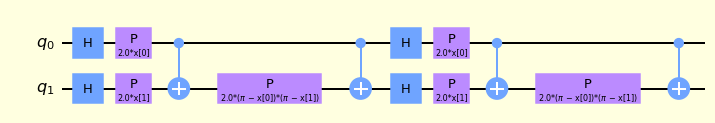

In [12]:
# An arbitrary feature map can have various layers, but in our example
# we only have rotation and entangling layers, and the rotation layer contains a 
# single Hadamard gate. For details of how to implement layers more generally,
# see qiskit/circuit/library/n_local/n_local.py. 

# The code below is adapted from the code in:
# qiskit/circuit/library/n_local/n_local.py and 
# qiskit/circuit/library/data_preparation/pauli_feature_map.py

paulis = ['Z', 'ZZ']  # List of Pauli operators to apply in the feature map
reps = 2  # Number of times the set of Pauli operators is repeated in the feature map

# Set the classical mapping function
# - this function is used to generate the symbolic expression that we wish to evaluate
# - the input is an array of Parameters (symbolic objects)
# - the output is a ParameterExpression (the symbolic object resulting from the symbolic expression)
def simple_product(x: np.ndarray) -> float:
    # This implements the classical mapping, φ (see the Equation above)
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.pi - x)
    return coeff

# Store a reference to the classical map
data_map_func = simple_product

# Create an empty parameter vector:
# - a ParameterVector is used for generating lists of parameters. It 
#   is essentially a list of Parameters, where each element is a Symbol 
#   of the form "name[index]" (Parameter's use symbolic maths: see the sympy library)
# - the label 'x' will be used to refer to a given sample
ordered_parameters = ParameterVector(name='x', length=feature_dim)
# → ordered_parameters is essentially a list containing Symbols 'x[0]' and 'x[1]'

# Create an empty parameter table
# - a Parameter table tracks instructions with variable parameters
# - it is essentially a dictionary where:
#   - the keys are Parameters
#   - the value associated with a given key (i.e. Parameter) is a list of (Instruction, index) tuples,
#     where "index' is the parameter index at which the parameter appears in the instruction.
parameter_table = ParameterTable()

# Create the rotation block
h = HGate()
circuit = QuantumCircuit(h.num_qubits)
circuit.append(h, [0])
rotation_blocks = [circuit]

# Loop over the number of repetitions in the feature map
feature_map = QuantumCircuit(*qregs)
for rep_no in range(reps):
    ################################
    # Build the rotation layer     #
    ################################
    # - this loop is only for generality: in the current case with
    #   2 qubits there will only be one rotation block
    for block_no, block in enumerate(rotation_blocks):
        # Create an empty circuit
        layer = QuantumCircuit(*qregs)

        # The rotation gates are stacked on top of each other.
        #   e.g. if we have 4 qubits and a rotation block of width 2, we apply two instances
        no_of_stacked_blocks = num_qubits // block.num_qubits
        # Determine which qubits are involved in each block in the stack
        # - if there are two stacked blocks and the block has 1 qubit (e.g. a H gate),
        #   this yields [[0], [1]]
        block_indices = [
            list(range(k * block.num_qubits, (k + 1) * block.num_qubits))
            for k in range(no_of_stacked_blocks)
        ]

        # Set the qubits used by the current block e.g. H-gate applied to qubit 1
        # - in the current case this results in 'layer' consisting of:
        #          ┌───┐
        # qubit 0: ┤ H ├
        #          ├───┤
        # qubit 1: ┤ H ├
        #          └───┘  
        for indices in block_indices:
            layer.compose(block, indices, inplace=True)

        # Add the layer to the circuit
        feature_map += layer

    ################################
    # Build the entanglement layer #
    ################################
    # 1. Build the entanglement blocks
    #    - this creates a lists of circuits, one circuit for each block
    #      e.g. a circuit implementing 'Z' and another circuit implementing 'ZZ'
    entanglement_blocks = []
    for pauli_string in paulis:
        # Create a parameter vector
        # - a dummy name is used as this parameter vector is a temporary "placeholder"
        # - the length = number of qubits e.g. 'Z' is a single qubit operator,
        #   while 'ZZ' is a two-qubit operator
        params = ParameterVector('_', length=len(pauli_string))
        # Construct the ParameterExpression implementing the classical mapping:
        #    φ(x) = x and φ(x,y) = (π - x)(π - y)
        time = data_map_func(np.asarray(params))
        # - this yields:
        #   1. for a single qubit operation applied to qubit i, where i ∈ [0, 1]:
        #        time = 2*x[i] (at this stage the name is '_', not 'x')
        #   2. for a two qubit operation:
        #        time = 2*(π - x[0]) * (π - x[1]))

        # Get the evolution block for the given pauli string
        # - first, need to reverse the order
        pauli_string = pauli_string[::-1]

        # Build a list of the qubit indicies
        indices = []
        for i, _ in enumerate(pauli_string):
            indices += [i]

        # Create a quantum circuit with the required number of qubits
        # i.e. one qubit for 'Z', and 2 qubits for 'ZZ'
        evo = QuantumCircuit(len(pauli_string))

        # Insert a stack of controlled-X gates
        # - in the current case this yields:
        #    a) nothing when processing the Z Pauli
        #    b) the following circuit when processing the ZZ Pauli:
        #       qubit 0: ──■───
        #                ┌─┴─┐
        #       qubit 1: ┤ X ├
        #                └───┘
        num_cx = len(indices) - 1
        for i in range(num_cx):
            evo.cx(indices[i], indices[i + 1])

        # Apply the U1 rotation, where the argument is the output from the classical map
        # - the argument is a ParameterExpression, for example: '2*(π - x[0]) * (π - x[1]))'
        #   Note: the label 'x' was used in the example above to indicate we are referring to
        #         components of a given sample 'x', however at this stage the parameter name
        #         is actually '_' (the mapping to real parameter names is done in Step 2 below).
        # - len(pauli_string)-1 applies the rotation to the last qubit in a multi-qubit
        #   operation, such as 'ZZ' (this assumes the last Pauli in the string is
        #   not I, for example ZYI)
        # - in the current case this yields:
        #    a) when processing the Z Pauli:
        #                ┌──────────────┐
        #       qubit 0: ┤ U1(2.0*x[0]) ├
        #                └──────────────┘
        #    b) when processing the ZZ Pauli:
        #                ┌───────────────────────────────┐
        #       qubit 1: ┤ U1(2.0*(π - x[0])*(π - x[1])) ├
        #                └───────────────────────────────┘
        #       Note: at this stage the labels are still '_', not 'x'
        qiskit_minor_version = __qiskit_version__['qiskit'].split('.')[1]
        if int(qiskit_minor_version) > 19:
            # U1 was replaced by P
            evo.p(2.0 * time, len(pauli_string) - 1)
        else:
            evo.u1(2.0 * time, len(pauli_string) - 1)

        # Insert a stack of controlled-X gates
        for i in range(num_cx):
            evo.cx(indices[i], indices[i + 1])

        entanglement_blocks.append(evo)

    # In the current case, we have two entanglement blocks at this stage:
    #    a)          ┌──────────────┐
    #       qubit 0: ┤ U1(2.0*x[0]) ├
    #                └──────────────┘
    #    b) 
    #       qubit 0: ──■─────────────────────────────────────■──
    #                ┌─┴─┐┌───────────────────────────────┐┌─┴─┐
    #       qubit 1: ┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
    #                └───┘└───────────────────────────────┘└───┘
    # Note: at this stage the labels are still '_', not 'x'
    
    # 2. Set the parameters in each entanglment block and
    #    add them to the relevant qubits in the feature map
    for block_no, block in enumerate(entanglement_blocks):
        # Create an empty circuit
        layer = QuantumCircuit(*qregs)

        # Create an "entangling map"
        # - this is a 2D list of qubit indices specifying which qubits are being operated
        #   on in the current block
        n = num_qubits
        m = block.num_qubits
        # Given the no.of qubits in the circuit (n) is two:
        #  - if the no. of qubits in the current block (m) is 1, this returns [[0], [1]]
        #  - if the no. of qubits in the current block (m) is 2, this returns [[0,1]]
        entangler_map = list(combinations(list(range(n)), m))

        # Parameterise the current block
        for indices in entangler_map:
            # Use the ParameterVector to generate the indices of the input data:
            # - if the index is 0, the Parameter returned is 'x[0]'' (and similarly 'x[1]'' if the index is 1)
            # - if the indices are 0,1, the Parameters returned are 'x[0]' and 'x[1]'
            # (recall the ParameterVector was created with name='x')
            params = [ordered_parameters[i] for i in indices]

            # The block was built with Parameters '_[0]' for a single qubit operator, and
            # Parameters '_[0]' and '_[1]' for a two qubit operator
            # - pack the parameters of the block with the parameters generated above
            update = dict(zip(block.parameters, params))

            # Assign the parameters and return a new block
            # Note: the blocks were created using a "temporary" ParameterVector, which was a placeholder
            #       that enabled us to specify the number of parameters to each block. Here we specify
            #       exactly which parameters are passed. For example, for the single qubit
            #       operator Z, the entanglement block was built with Parameter '_[0]'. In this
            #       loop we apply the Z operator:
            #       - to qubit 0, so the original '_[0]' Parameter is replaced with the 'x[0]' Parameter
            #       - to qubit 1, so the original '_[0]' Parameter is replaced with the 'x[1]' Parameter
            # → this is why the "temporary" ParameterVector was used.
            #   Note: For the two qubit ZZ operator the initial construction with the "temporary"
            #         ParameterVector was not neccessary (it was created with Parameters
            #         '_[0]' and '_[1]', which are replaced here with Parameters 'x[0]' and 'x[1]'.
            #         In this case it could have been created with the 'x[0]' and 'x[1]'
            #         Parameters directly
            parametrized_block = block.assign_parameters(update)

            # Add the current block to the specified qubits in the circuit
            layer.compose(parametrized_block, indices, inplace=True)

        # Add the layer to the circuit
        feature_map += layer

# Draw the feature map circuit
style = {'backgroundcolor': 'lightyellow'}  # Style only works in matplotlib backend
#feature_map.draw(output='latex', plot_barriers=True, reverse_bits=True, scale=0.5)
feature_map.draw(output='mpl', plot_barriers=True, reverse_bits=False, style=style)

### Computing the state overlap
For our quantum algorithm to be of practical use on current hardware, we need
an efficient method for computing the state overlap (*i.e.* the kernel function). The state overlap algorithm must be efficient 
because we need to compute the overlap between all unique pairs of
samples in the training set (when constructing the kernel matrix), and
also between all support vectors and a given test sample (during the
classification stage).

The "*swap*" test is commonly used for computing the overlap or *fidelity* between two states, with the overlap given by the expectation value of the SWAP operator:
\begin{equation}
\label{expect_val}
\left<\textrm{SWAP}\right>_{\ket{\phi(\mathbf{x}) \otimes \phi(\mathbf{y})}} = 
\bra{\phi(\mathbf{x}) \otimes \phi(\mathbf{y})} \textrm{SWAP} \ket{\phi(\mathbf{x}) \otimes \phi(\mathbf{y})} = \left| \braket{\phi(\mathbf{x})}{\phi(\mathbf{y})} \right|^2.
\end{equation}
The "*swap*" test is not suitable for use on current devices, so we use the Bell-Basis algorithm proposed by Cincio *et al.*<sup>[1]</sup>. 
The Bell-Basis algorithm is a relatively short-depth circuit (the number of gates scales linearly with the number of qubits) and therefore likely to yield better results on noisy devices. To understand the algorithm, first consider the single qubit case, for which the circuit is:

<div>
<img src="bell_basis_algorithm_for_SWAP_test_single_qubit.png">
</div>

(see Figure 6a in Cincio *et al.*). The overlap is given by:
\begin{equation}
\label{post_proc}
\sum_i c_i \,p_i
\end{equation}
where $\mathbf{c} = \left(1, 1 ,1, -1\right)$ and the $p_i$ are measurement probabilities for the $00$, $01$, $10$ and $11$ outcomes. 
***
&#9998; Consider the measurement of an arbitrary single qubit state, $\ket{\psi}$. When measuring in $Z$, we have (projective) measurement operators:
\begin{eqnarray}
\label{measure_ops}
P_0 &=& \ket{0}\!\bra{0} \\
P_1 &=& \ket{1}\!\bra{1} \nonumber
\end{eqnarray} 
and the corresponding probabilities of the measurement outcomes are:
\begin{eqnarray}
\label{measure_probs}
p(m\!=\!0) &=& \bra{\psi} P_0 \ket{\psi} = \braket{\psi}{0}\braket{0}{\psi} = \left| \braket{\psi}{0} \right |^2 \\
p(m\!=\!1) &=& \bra{\psi} P_1 \ket{\psi} = \braket{\psi}{1}\braket{1}{\psi} = \left| \braket{\psi}{1} \right |^2 \nonumber .
\end{eqnarray}
In general, the probability of measuring $n$ qubits in $Z$ and obtaining bit string $\ket{x_1 \ldots x_n}$ is $\left| \braket{x_1 \ldots x_n}{\psi} \right |^2$. Applying the post-processing step in the Bell-Basis algorithm (Equation \ref{post_proc}) to an arbitrary 2-qubit state $\ket{\psi \otimes \phi}$ yields:
\begin{eqnarray}
\label{post_proc_v2}
\sum\nolimits_i c_i \,p_i &=& 1 \times \left| \braket{00}{\psi \otimes \phi} \right | ^2 \\
                          &+& 1 \times \left| \braket{01}{\psi \otimes \phi} \right | ^2 \nonumber \\
                          &+& 1 \times \left| \braket{10}{\psi \otimes \phi} \right | ^2 \nonumber \\
                          &-& 1 \times \left| \braket{11}{\psi \otimes \phi} \right | ^2 \nonumber .
\end{eqnarray}
If we recall CZ has eigenvalues $\lambda_i = \left(1, 1 ,1, -1\right)$ and eigenvectors $\Psi_i = \ket{00}, \ket{01}, \ket{10}$ and $\ket{11}$, we see the post-processing step (Equation \ref{post_proc_v2}) yields the expectation value of the controlled-Z operator, expressed using its spectral decomposition:
\begin{equation}
\label{expect_val_CtrlZ}
\left<\textrm{CZ}\right>_{\ket{\psi \otimes \phi}} = 
\bra{\psi \otimes \phi} \textrm{CZ} \ket{\psi \otimes \phi)} =
\sum_i \lambda_i \left| \braket{\Psi_i}{\psi \otimes \phi} \right| ^2.
\end{equation}

In this case, measurement of the original state $\ket{\psi \otimes \phi}$ yielded the expectation value of the CZ operator. However, we seek the state overlap which is given by the expectation value of the SWAP operator. To proceed we note that the circuit in the Bell-Basis algorithm consists of a CNOT and Hadamard gate, so the state being measured is:
\begin{equation}
\label{define_new_state}
\ket{\Phi} = \left( H \otimes I \right) . CNOT_{1 \rightarrow 2} . \ket{\psi \otimes \phi}.
\end{equation}
With a suitable number of shots we can estimate the measurement probabilities 
$\left| \braket{00}{\Phi_i} \right| ^2, \left| \braket{01}{\Phi_i} \right| ^2$ *etc.*, and the post-processing step now yields:
\begin{eqnarray}
\label{post_proc_v3}
\sum\nolimits_i c_i \,p_i &=& 1 \times \left| \braket{00}{\Phi} \right | ^2 \\
                          &+& 1 \times \left| \braket{01}{\Phi} \right | ^2 \nonumber \\
                          &+& 1 \times \left| \braket{10}{\Phi} \right | ^2 \nonumber \\
                          &-& 1 \times \left| \braket{11}{\Phi} \right | ^2 \nonumber
\end{eqnarray}
which is the desired expectation value of the SWAP operator for the the state $\ket{\psi \otimes \phi}$ *i.e.* $\left<\textrm{SWAP}\right>_{\ket{\psi \otimes \phi}}$. Note: $\ket{01}$ and $\ket{10}$ are not eigenvectors of the SWAP operator, so Equation \ref{post_proc_v3} is not a spectal decomposition (whereas Equation \ref{post_proc_v2} is). 
***
The circuit implementing Cincio *et al.*'s algorithm for computing the overlap between two $n$-qubit states $\ket{\phi(\mathbf{x})}$ and $\ket{\phi(\mathbf{y})}$ is: 
<div>
<img src="bell_basis_algorithm_for_SWAP_test.png">
</div>
(see Figure 6b in Cincio \emph{et al.}).

The circuit appears to be relatively deep and therefore unlikely to yield usable results on noisy hardware. However, the algorithm is efficient because:<br>
1. the CNOT and Hadamard gates for each pair of qubits (see the single qubit circuit above) can be executed in parallel; and<br>
2. the expectation value of the $n$-qubit system can be obtained from the expectation values of the two-qubit pairs.<br>

To understand how the multiqubit SWAP gate works, we:<br>
1. decompose the multiqubit SWAP gate into a product of two-qubit swap gates:
\begin{equation}
\textrm{SWAP} = \prod_{k=1}^n \textrm{SWAP}_{s_kt_k},
\end{equation}
2. diagonalize each two-qubit SWAP using $CNOT_{i\rightarrow j} H_i$ (see the single qubit circuit above)<br>
3. measure each two-qubit pair, obtaining the eigenvalue $(-1)^{s_it_i}$<br>
4. combine the results for all the two-qubit pairs:
\begin{equation}
\label{final_sum}
f(s,t) = (-1)^{s_1t_1 + \ldots + s_nt_n}.
\end{equation}
Averaging the result (Equation \ref{final_sum}) over many shots yields the desired overlap.
<br>

The method described above can be used to compute the overlap between arbitrary input states $\ket{\psi}$ and $\ket{\phi}$. In our application however, the overlap can be computed more easily because the input states are structured by design. Recall our input states were created by applying the feature map $\mathcal{U}_{\Phi(\mathbf{x})}$ (see the Equation) to the reference state $\ket{0^n}$. The desired overlap:
\begin{eqnarray}
\left| \braket{\phi(\mathbf{x})}{\phi(\mathbf{y})} \right|^2 &=&
\left| \bra{0^n} \mathcal{U}_{\Phi(\mathbf{x})}^{\dagger} \mathcal{U}_{\Phi(\mathbf{x})} \ket{0^n} \right|^2 \\
&=&\left| \braket{0^n}{\mathcal{U}_{\Phi(\mathbf{x})}^{\dagger} \mathcal{U}_{\Phi(\mathbf{x})} 0^n} \right|^2 \nonumber
\end{eqnarray}
which is simply the probability of measuring bit string $\ket{0^n}$ on state $\mathcal{U}_{\Phi(\mathbf{x})}^{\dagger} \mathcal{U}_{\Phi(\mathbf{x})}\ket{0^n}$. The probability (and therefore the overlap) can be estimated by preparing multiple copies of the state $\mathcal{U}_{\Phi(\mathbf{x})}^{\dagger} \mathcal{U}_{\Phi(\mathbf{x})}\ket{0^n}$ and measuring each one in the computational basis. The overlap is given by the fraction of samples for which the $0^n$ bit string was observed.

<br><br>
<sup>[1]</sup> Lukasz Cincio, Yiğit Subaşı, Andrew T. Sornborger, Patrick J. Coles. "Learning the quantum algorithm for state overlap", New J. Phys. 20, 113022 (2018) DOI: [10.1088/1367-2630/aae94a](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1088%2F1367-2630%2Faae94a&v=eb9c4c5d). An online copy is available [here](https://arxiv.org/abs/1803.04114).

The function below:
1. maps the classical samples into quantum states (using the feature map defined above)
2. computes the state overlap between all unique pairs of states.

You may find it easier to understand this function if you first read the cell which calls this function (the cell below the function definition).

In [16]:
# The code below is adapted from the code in:
#   qiskit/circuit/aqua/algorithms/classifiers/qsvm/qsvm.py and
#   qiskit/circuit/aqua/algorithms/classifiers/qsvm/_qsvm_binary.py.

def get_kernel_matrix(quantum_instance, feature_map, qregs, x1_vec, x2_vec,
                      show_circuit=False, is_symmetric=True):
    """
        Function constructs the kernel matrix i.e. state overlap between the samples
        in x1_vec and x2_vec.
        
        When this function is being used to compute the kernel matrix for training,
        the state overlap will be computed between all unique pairs of training samples
        so the resulting matrix will be symmetric. In this case x1_vec and x2_vec are 
        identical and both contain the training samples.
        
        When this function is being used to compute the kernel matrix for evaluation (of the 
        SVM) or prediction (i.e. classifying unseen samples), the state overlap will be computed
        between all unique pairs of support vectors and samples (either training samples for 
        evaluation or test samples for prediction), so the resulting matrix will usually be 
        non-symmetric. In this case x1_vec will contain the samples and x2_vec will contain 
        the support vectors.
    
        Args:
            quantum_instance (QuantumInstance): quantum backend with all settings
            feature_map (FeatureMap): a feature map that maps data to feature space
            qregs (list):           a list of QuantumRegisters
            x1_vec (numpy.ndarray): data points, 2-D array, N1xD, where N1 is the number of data,
                                    D is the feature dimension
            x2_vec (numpy.ndarray): data points, 2-D array, N2xD, where N2 is the number of data,
                                    D is the feature dimension
            is_symmetric (bool):    indicates if the kernel matrix will be symmetric
        Returns:
            numpy.ndarray: 2-D matrix, N1xN2
    """
    
    # Measurement will be done in the z-axis
    measurement_basis = '0' * feature_map.num_qubits
    
    # The dimension is used when creating parameter vectors (below)
    feature_map.feature_dimension = len(feature_map.parameters)
    
    ###############################
    # Construct the kernel matrix #
    ###############################
    # - the matrix element i,j is the overlap between the mapped samples i and j
    no_samples = len(x1_vec)        # x1_vec contains training or test samples
    no_samples_or_SVs = len(x2_vec) # x2_vec contains training samples or support vectors
    kernel_matrix = np.ones((no_samples, no_samples_or_SVs))
    
    # Get the indices of all sample pairs
    if is_symmetric:
        # Get the upper triangle of the matrix (offset k=1 skips the diagonal)
        mus, nus = np.triu_indices(no_samples, k=1)
    else:
        mus, nus = np.indices((no_samples, no_samples_or_SVs))
        mus = np.asarray(mus.flat)
        nus = np.asarray(nus.flat)
    
    # The matrix is computed in blocks (this may be useful if the no. of samples is large)
    BATCH_SIZE = 1000
    for idx in range(0, len(mus), BATCH_SIZE):
        to_be_computed_data_pair = []
        to_be_computed_index = []
        # Construct a list containing pairs of indices: the overlap will be computed
        # between the two samples defined by the indices in each pair
        for sub_idx in range(idx, min(idx + BATCH_SIZE, len(mus))):
            i = mus[sub_idx]  # Row index
            j = nus[sub_idx]  # Column index
            x1 = x1_vec[i] # This could be a training or test sample
            x2 = x2_vec[j] # This could be a training sample or support vector
            # If the two samples are not identical, add them to the list of sample pairs
            # (the overlap will be computed for each pair of samples in the list)
            if not np.all(x1 == x2):
                to_be_computed_data_pair.append((x1, x2))
                to_be_computed_index.append((i, j))
    
        # The parameter vectors contain: ['x[0]', 'x[1]'] and ['y[0]', 'y[1]']
        feature_map_params_x = ParameterVector('x', feature_map.feature_dimension)
        feature_map_params_y = ParameterVector('y', feature_map.feature_dimension)
    
        # Construct a parameterised circuit to compute the overlap
        q = QuantumRegister(feature_map.num_qubits, 'q')
        c = ClassicalRegister(feature_map.num_qubits, 'c')
        parameterised_circuit = QuantumCircuit(q, c)
    
        # Circuit to map sample x1 to φ(x)
        param_dict = dict(zip(ordered_parameters, feature_map_params_x))
        # The feature map refers to x[0] and x[1]. This code 
        psi_x1 = feature_map.assign_parameters(param_dict)
        parameterised_circuit.append(psi_x1.to_instruction(), parameterised_circuit.qubits)
    
        # At this stage, the parameterised circuit contains the gates
        # required to map the sample x1 into feature space i.e two repetitions of this:
        #      ┌───┐┌──────────────┐
        # q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
        #      ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
        # q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
        #      └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘
        # which creates the ket |φ(x)〉
        
        # Circuit to map sample x2 to φ(y)
        # - the parameters x[0], x[1] in the feature map are mapped to y[0], y[1]
        param_dict = dict(zip(ordered_parameters, feature_map_params_y))
        psi_x2_dag = feature_map.assign_parameters(param_dict)
        parameterised_circuit.append(psi_x2_dag.to_instruction().inverse(), parameterised_circuit.qubits)
    
        # The parameterised circuit now also contains the gates required to create
        # the bra: 〈φ(y)|
        
        # Measure in the z-basis
        parameterised_circuit.barrier(q)
        parameterised_circuit.measure(q, c)
    
        # if idx == 0:
        # print("Circuit before being transpiled has type:", type(parameterised_circuit))
        # print("Circuit before being transpiled:", parameterised_circuit)
        # parameterised_circuit.draw(output='latex', plot_barriers=True, reverse_bits=False, scale=0.5)
    
        # Transpile the parameterised circuit
        # - the alternative approach (apply parameters first and then transpiling multiple circuits)
        #   is less efficient
        parameterised_circuit = quantum_instance.transpile(parameterised_circuit)[0]
    
        # Display the transpiled circuit, if requested
        if show_circuit:
            print("Circuit after being transpiled, but before parameterisation:")
            show_figure(parameterised_circuit.draw(output='mpl', plot_barriers=True, reverse_bits=False, scale=0.9))
    
        # For each pair of samples for which we need to compute the overlap (i.e. entry in
        # the kernel matrix), we create a circuit. This is done by assigning values to the parameters:
        # - up to this point we have had a single parameterised_circuit. The lambda function
        #   creates a set of circuits; one circuit for each pair of samples between which
        #   the overlap is to be computed. Each circuit is obtained by replacing the parameters
        #   with the coefficients from the respective samples.
        circuits = [
            # To create a circuit for a given pair of samples, pass two dict's, each consisting of
            # a parameter vector and the values that will be substituted for the parameters
            parameterised_circuit.assign_parameters({feature_map_params_x: x, feature_map_params_y: y})
            for x, y in to_be_computed_data_pair
            # In the lambda:
            # - x is an array containing the two coefficients of the x1 sample: these values
            #   are assigned to x[0] and x[1] in the parameterised circuit
            # - y is an array containing the two coefficients of the x2 sample: these values
            #   are assigned to y[0] and y[1] in the parameterised circuit
        ]
        
        # Display a subset of the parameterised circuits, if requested
        no_print = min(3, len(to_be_computed_data_pair))
        if show_circuit:
            if idx == 0:
                for c_idx in range(no_print):
                    (i, j) = to_be_computed_index[c_idx]
                    print("Complete circuits for computing the overlap between samples: {:d}, {:d}:".format(i, j))
                    show_figure(circuits[c_idx].draw(output='mpl', plot_barriers=True, reverse_bits=False, scale=0.9))
    
        # Execute the circuits
        results = quantum_instance.execute(circuits, had_transpiled=True)
        
        # For each circuit, convert the count into the overlap
        # - if there are a lot of circuits it may be more efficient to do this task in parallel
        # (Qiskit has tools for doing tasks in parallel)
        matrix_elements = []
        for circuit_idx in range(len(circuits)):
            circuit_result = results.get_counts(circuit_idx)
            kernel_value = circuit_result.get(measurement_basis, 0) / sum(circuit_result.values())
            matrix_elements.append(kernel_value)
    
        # Insert the values into the kernel matrix
        for (i, j), value in zip(to_be_computed_index, matrix_elements):
            kernel_matrix[i, j] = value
            if is_symmetric:
                kernel_matrix[j, i] = value
    
    # If the kernel matrix is (ideally) symmetric, it should be positive semi-definite by
    # construction. However, the actual matrix may not be exactly PSD due to the effects
    # noise etc. In this step we attempt to find the PSD matrix that is closest to the
    # actual matrix we obtained.
    if is_symmetric:
        # Step 1. Compute the eigenvalues (D) and normalised (right) eigenvectors (U)
        D, U = np.linalg.eig(kernel_matrix)
        # Step 2. Correct any negative eigenvalues
        Dc = np.diag(np.maximum(0, D))
        #                                                 T
        # Step 3. Compute the nearest PSD approximation: U . Dc. U, where:
        #         U is a matrix with columns containing the normalised eigenvectors
        #         Dc is a diagonal matrix containing the (corrected) eigenvalues
        #         T is the transpose
        corrected_kernel_matrix = U @ Dc @ U.transpose()
    
    # Display the matrix
    if True:
        # Display the matrix as an image
        img = plt.imshow(kernel_matrix, interpolation='nearest', origin='upper', cmap='bone_r')
        plt.title('Matrix of state overlaps')
        plt.show()
        # Display the corrected matrix
        if is_symmetric:
            img = plt.imshow(corrected_kernel_matrix, interpolation='nearest', origin='upper', cmap='bone_r')
            plt.title('Matrix of state overlaps (after PSD correction)')
            plt.show()
    if False:
        # Output a subset of the individual matrix elements
        max_elements = min(2*max(no_samples,no_samples_or_SVs), no_samples*no_samples_or_SVs)
        print("Will output {} elements of the kernel matrix".format(max_elements))
        element_count = 0
        for row in range(no_samples):
            if element_count >= max_elements:
                break
            for col in range(row, no_samples_or_SVs):
                element_count += 1
                if is_symmetric:
                    print("Kernel({:4d}, {:4d}): {:12.10f}, corrected: {:12.10f}".format(
                          row, col, kernel_matrix[row, col], corrected_kernel_matrix[row, col]))
                else:
                    print("Kernel({:4d}, {:4d}): {:12.10f}".format(
                          row, col, kernel_matrix[row, col]))
                if element_count >= max_elements:
                    break
    
    if is_symmetric:
        return corrected_kernel_matrix
    else:
        return kernel_matrix

### Construct the Support Vector Machine

In the preceding sections we showed how to construct the circuits for:
1. implementing the feature map, and
2. computing the state overlap.

Given these tools, we can now construct and use our quantum-enhanced support vector machine as follows:
1. construct the SVM (using a standard classical algorithm to find the optimal support vectors)
2. evaluate the SVM using samples in the training dataset
3. use the SVM to classify samples in the test dataset.

In the cell below we construct the SVM in two steps:
1. compute the kernel matrix for the samples in the training set
2. use the optimizer to select the support vectors and compute the associated weights and bias.

We also display the circuits used to compute the state overlap between a few samples.

Circuit after being transpiled, but before parameterisation:


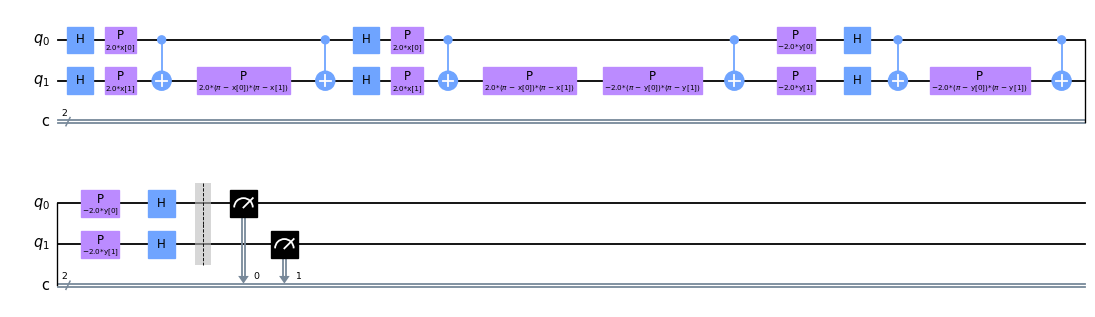

Complete circuits for computing the overlap between samples: 0, 1:


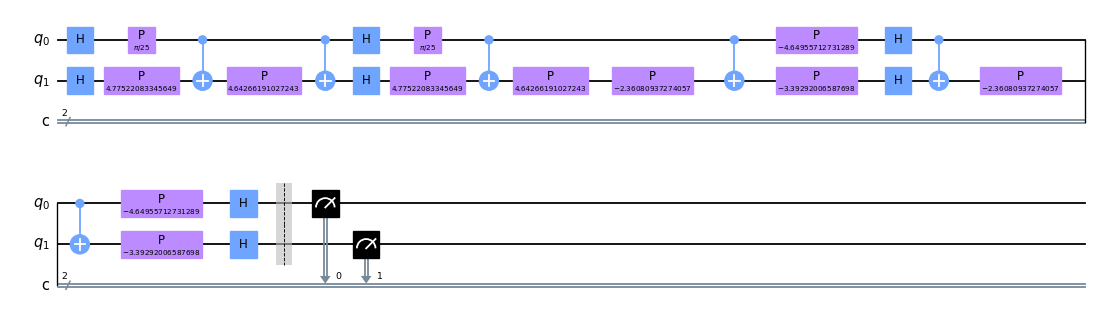

Complete circuits for computing the overlap between samples: 0, 2:


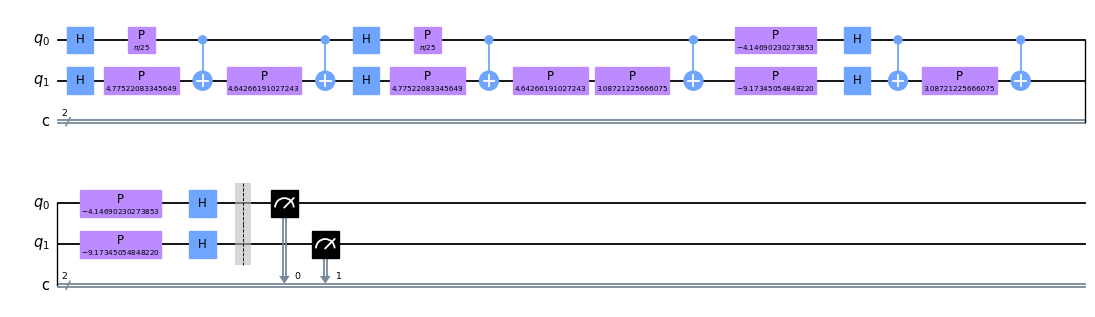

Complete circuits for computing the overlap between samples: 0, 3:


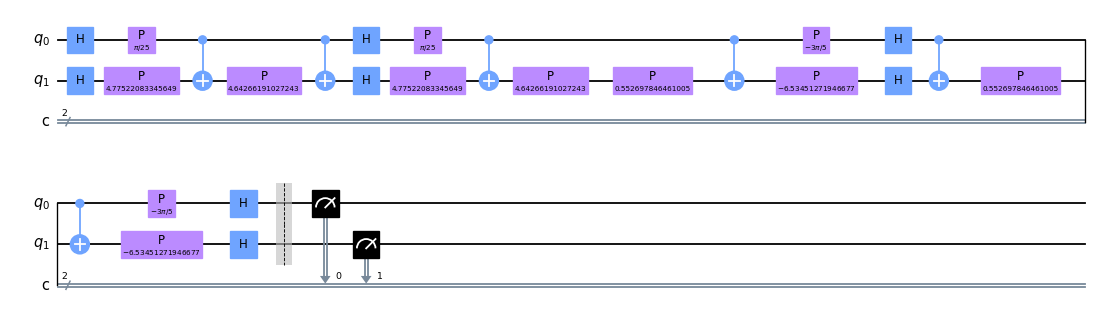

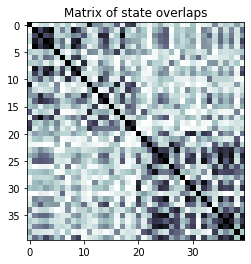

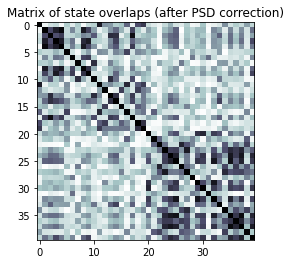

Results of optimisation:
Support vector (sample 0) has weight: 0.40969 and label -1
Support vector (sample 2) has weight: 1.74394 and label -1
Support vector (sample 5) has weight: 2.35350 and label -1
Support vector (sample 6) has weight: 2.36966 and label -1
Support vector (sample 7) has weight: 1.06307 and label -1
Support vector (sample 9) has weight: 0.16697 and label -1
Support vector (sample 15) has weight: 0.51225 and label -1
Support vector (sample 17) has weight: 1.01944 and label -1
Support vector (sample 27) has weight: 0.40935 and label 1
Support vector (sample 28) has weight: 2.26922 and label 1
Support vector (sample 31) has weight: 1.13275 and label 1
Support vector (sample 33) has weight: 3.37865 and label 1
Support vector (sample 38) has weight: 0.53588 and label 1
Support vector (sample 39) has weight: 1.91266 and label 1
Bias: -0.237581


In [17]:
# Get the training samples: data are at index 0, labels are at index 1
data = training_dataset[0]
    
# Call the function to compute the kernel matrix that will be used for training
kernel_matrix = get_kernel_matrix(quantum_instance, feature_map, qregs, data, data,
                                  show_circuit=True)

# L2 norm regularization factor (for the optimisation)
lambda2 = 0.001

# Get the labels for the training samples
# - is a numpy 1-D array of numeric labels (0 or 1), corresponding to each sample
labels = training_dataset[1]    
    
# Map the labels 0 --> -1 and 1 --> 1, and convert to floats
labels = labels * 2 - 1  # map label from 0 --> -1 and 1 --> 1
labels = labels.astype(float)

# Identify the optimal support vectors and return the weights (alpha) and bias (b)
[alpha, bias, support] = optimize_svm(kernel_matrix, labels, scaling=None, lambda2=lambda2)
support_index = np.where(support)
alphas = alpha[support_index]
svms = data[support_index]
yin = labels[support_index]

print("Results of optimisation:")
support_index = 0
for index, is_support in enumerate(support):
    if is_support:
        print("Support vector (sample {:d}) has weight: {:.5f} and label {}".format(
              index, alpha[index], int(labels[index])))
print("Bias: {:.6f}".format(bias[0]))

In the cell below we evaluate the SVM using samples in the training dataset.

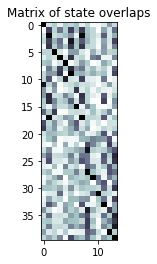

100.0 % of training samples were correctly classified


In [18]:
# Get the training samples: data are at index 0, labels are at index 1
data = training_dataset[0]
labels = training_dataset[1] 
    
# Call the function to compute the kernel matrix that will be used during the evaluation
kernel_matrix = get_kernel_matrix(quantum_instance, feature_map, qregs, data, svms, is_symmetric=False)

# Compute the classification (-1.0 or 1.0) for each test sample
# - samples with weighted value (w.x +b) >= 1.0 are assigned 1.0
# - samples with weighted value (w.x +b) <= -1.0 are assigned -1.0
wx_plus_b  = np.sum(yin * alphas * kernel_matrix, axis=1) + bias
  
# Map the classifications: -1 --> 0, 1 --> 1
binarized_classifications = (np.sign(wx_plus_b) + 1) / 2
predicted_labels = binarized_classifications.astype(int)

# Compute the proportion of samples that were correctly classified
accuracy = np.sum(predicted_labels == labels.astype(int)) / labels.shape[0]
print("{:.1f} % of training samples were correctly classified".format(accuracy * 100.0))

In the cell below we use the SVM to classify (unseen) samples in the test dataset.

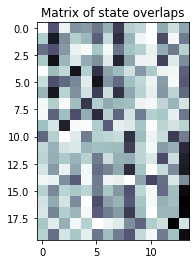

100.0 % of test samples were correctly classified


In [19]:
# Get the test samples: data are at index 0, labels are at index 1
data = test_dataset[0]
labels = test_dataset[1] 
    
# Call the function to compute the kernel matrix that will be used during testing
kernel_matrix = get_kernel_matrix(quantum_instance, feature_map, qregs, data, svms, is_symmetric=False)

# Compute the classification (-1.0 or 1.0) for each test sample
wx_plus_b  = np.sum(yin * alphas * kernel_matrix, axis=1) + bias
  
# Map the classifications: -1 --> 0, 1 --> 1
binarized_classifications = (np.sign(wx_plus_b) + 1) / 2
predicted_labels = binarized_classifications.astype(int)

# Compute the proportion of samples that were correctly classified
accuracy = np.sum(predicted_labels == labels.astype(int)) / labels.shape[0]
print("{:.1f} % of test samples were correctly classified".format(accuracy * 100.0))